In [2]:
import cupy as cp
import cv2
import numpy as np
from matplotlib import pyplot as plt
# from utils import PG

In [3]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol) * ncutoff)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), (1, 2) * cutoff, 0, 0, 360,  1, -1)

    mask = cp.asarray(mask)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered

In [4]:
def pg(zed_depth, vlp_depth, ncutoff, threshold=100):
    mask = ~cp.isnan(vlp_depth)
    filtered = zed_depth
    filtered[mask] = vlp_depth[mask]

    while threshold > 0:
        filtered = lpf(filtered, ncutoff)
        filtered[mask] = vlp_depth[mask]

        threshold -= 1

    return filtered

# Create chessboard

In [81]:
# ---------- parameters ----------
img_size = (720, 1280)  # overall image size  (rows, cols)
square_px = 32  # width/height of one square in pixels
colors = (0, 255)  # (dark, light) values – 0/255 gives black/white
dtype = cp.uint8  # output datatype
# --------------------------------

# Build row/column index grids on the GPU
rows, cols = cp.indices(img_size, dtype=cp.int32)

# Calculate which “square” each pixel belongs to, then XOR to alternate
checker = ((rows // square_px) ^ (cols // square_px)) & 1

# Map to chosen grayscale levels
x = cp.where(checker, colors[1], colors[0]).astype(cp.float32)  # stays on GPU

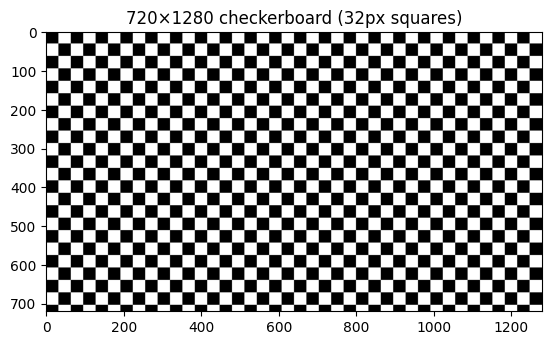

In [82]:
# Display
plt.imshow(x.get(), cmap='gray', vmin=0, vmax=255)
plt.title(f'{img_size[0]}×{img_size[1]} checkerboard ({square_px}px squares)')
plt.show()

In [83]:
m = 4  # downsampling coefficient
y = x[::m, ::m]  # input LR image

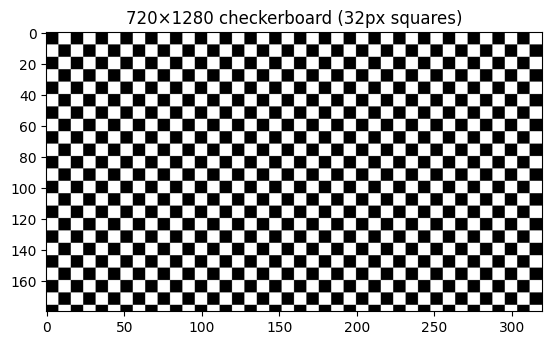

In [84]:
# Display
plt.imshow(y.get(), cmap='gray', vmin=0, vmax=255)
plt.title(f'{img_size[0]}×{img_size[1]} checkerboard ({square_px}px squares)')
plt.show()

In [85]:
z = cp.full(x.shape, fill_value=cp.nan, dtype=cp.float32)
z_display = cp.zeros(x.shape, dtype=cp.float32)
z[::m, ::m] = y
z_display[::m, ::m] = y

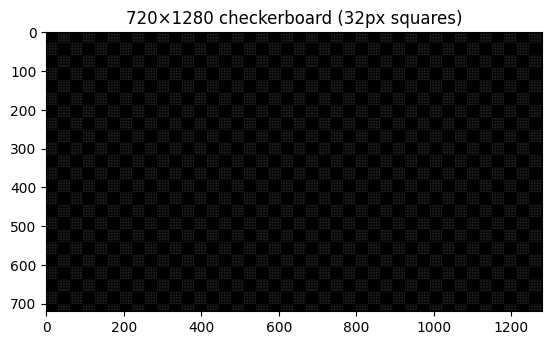

In [86]:
# Display
plt.imshow(z_display.get(), cmap='gray', vmin=0, vmax=255)
plt.title(f'{img_size[0]}×{img_size[1]} checkerboard ({square_px}px squares)')
plt.show()#%%


In [87]:
# --- assume img_gpu from previous snippet exists ---
sigma = 250.0                   # standard deviation (0–255 scale)
noise = cp.random.normal(0, sigma, x.shape).astype(cp.float32)

x_n = cp.clip(x + noise, 0, 255).astype(cp.float32)

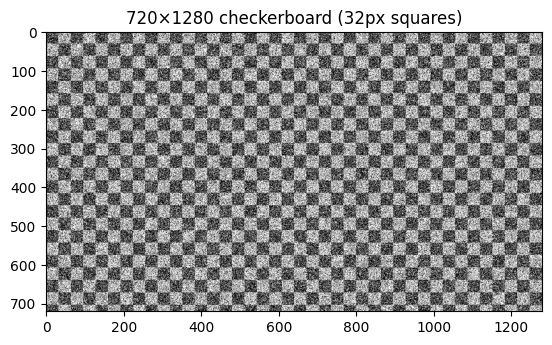

In [88]:
# Display
plt.imshow(x_n.get(), cmap='gray', vmin=0, vmax=255)
plt.title(f'{img_size[0]}×{img_size[1]} checkerboard ({square_px}px squares)')
plt.show()#%%

In [89]:
x_hat = pg(x_n.copy(), z.copy(), ncutoff=0.45, threshold=500)

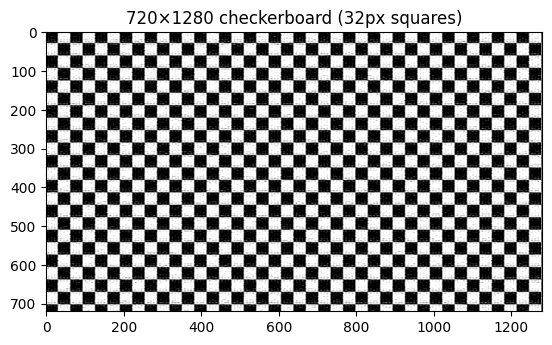

In [90]:
# Display
plt.imshow(x_hat.get(), cmap='gray', vmin=0, vmax=255)
plt.title(f'{img_size[0]}×{img_size[1]} checkerboard ({square_px}px squares)')
plt.show()#%%